<div class='bar_title'></div>

*Introduction to Data Science (IDS)*

# Assignment 10 - Spatial Regression Solution
Gunther Gust / Vanessa Haustein <br>
Chair for Enterprise AI<br>
Data Driven Decisions (D3) Group<br>
Center for Artificial Intelligence and Data Science (CAIDAS)

<img src='https://raw.githubusercontent.com/vhaus63/ids_data/main/d3.png?raw=true' style='width:20%; float:left;' />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/CAIDASlogo.png" style="width:20%; float:left;" />

# Exercise 1:

Referring to the lecture, remember how model 3 was built using a formula string. Explain in more detail why it is important that the intercept has to be omitted. Which two things could happen if we didn't ensure that?

Including an intercept term together with **all** neighborhood columns would result in multicollinearity. This means, that we would introduce a linear dependency between the intercept and the neighborhood categories.

Here is an example:

| log_price | neighborhood | neighborhood_A | neighborhood_B |
|-----------|--------------|----------------|----------------|
| 10        | A            | 1              | 0              |
| 12        | B            | 0              | 1              |
| 15        | A            | 1              | 0              |

If we include an intercept (`β₀`), the model looks like this:

$\text{log\_price} = \beta_0 + \beta_1 \cdot \text{neighborhood\_A} + \beta_2 \cdot \text{neighborhood\_B}$

Now, let's write the equations based on the data:

1. For the first observation (neighborhood A):
   
   $10 = \beta_0 + \beta_1 \cdot 1 + \beta_2 \cdot 0 \quad \Rightarrow \quad 10 = \beta_0 + \beta_1$
   
2. For the second observation (neighborhood B):
   
   $12 = \beta_0 + \beta_1 \cdot 0 + \beta_2 \cdot 1 \quad \Rightarrow \quad 12 = \beta_0 + \beta_2$

3. For the third observation (neighborhood A):
   
   $15 = \beta_0 + \beta_1 \cdot 1 + \beta_2 \cdot 0 \quad \Rightarrow \quad 15 = \beta_0 + \beta_1$

Notice that the first and third equations are the same, both involving `β₀ + β₁`. So, we now have:

1. $10 = \beta_0 + \beta_1$
2. $12 = \beta_0 + \beta_2$
3. $15 = \beta_0 + \beta_1$

Here, the equations are not independent of each other because both the first and third observations depend on `β₀ + β₁`, creating redundancy.

This redundancy leads to a problem in estimation: there are more equations than independent variables, and the system of equations becomes **underspecified**. Specifically, we can't estimate `β₁` and `β₀` separately because they are linked across the same set of observations.

# Exercise 2:

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/san_diego_pier.jpg" style="width:30%; float:center;" />

When you google San Diego Instagram Spots, one of the hottest search entries is the famous UCSD Scripps Pier. Maybe this landmark has an effect on the pricing of AirBnBs?

In order to check this assumption first find the coordinates of the pier (in particular, search for the Scripps Shoreline Underwater Reserve) using Nominatim. Then add the euclidean distance between the Insta spot and each point in the dataset as a new column.

Use [this link](https://geographicdata.science/book/data/airbnb/regression_cleaning.html) as a reference. It explains how the Balboa Park column was added and you can use the same procedure for the pier.

In [44]:
import geopandas as gpd
from geopy.geocoders import Nominatim
from scipy.spatial.distance import cdist
from shapely.geometry import Point
import contextily
import spreg
import pandas as pd

In [21]:
db =  gpd.read_file("https://raw.githubusercontent.com/GuntherGust/sc_gdsa_data/main/regression_db.geojson")

In [22]:
geolocator = Nominatim(user_agent='exercise')
sp = geolocator.geocode("Scripps Shoreline Underwater Reserve, San Diego, US")
sp

Location(Scripps Shoreline Underwater Reserve, San Diego County, California, 02037, United States, (32.8667137, -117.2555924, 0.0))

In [23]:
p_ll = sp.longitude, sp.latitude

In [24]:
# USA Contiguous Albers Equal Area (m.)
# http://epsg.io/102003
tgt_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 "\
          "+lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"

b_xy = gpd.GeoSeries(Point(p_ll), crs=db.crs).to_crs(tgt_crs)[0]
b_xy = (b_xy.x, b_xy.y)
# Calculate distance in Km.
d2b = lambda pt: cdist([(pt.x, pt.y)], [b_xy])[0][0] / 1000

Plot your results.

<Axes: >

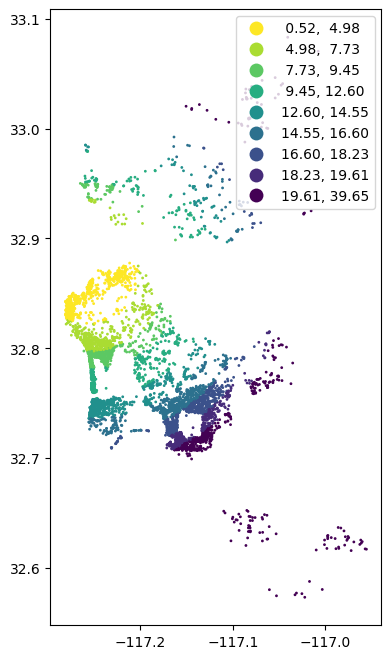

In [27]:
db['d2instaspot'] = db['geometry'].to_crs(tgt_crs).apply(d2b)
db.plot(column='d2instaspot', scheme='quantiles', k=9, cmap='viridis_r', s=1, legend=True, figsize=(12, 8))

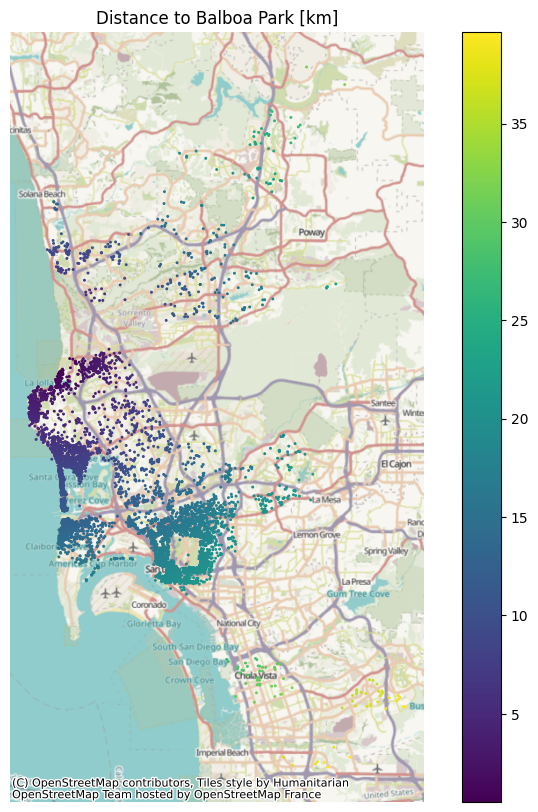

In [30]:
ax = db.plot(column="d2instaspot", marker=".", s=5, legend = True, figsize=(10,10))
contextily.add_basemap(ax, crs=db.crs)
ax.set_title("Distance to Balboa Park [km]")
ax.set_axis_off();

First, train a linear model without spatial features.

In [37]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [38]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    y= db[["log_price"]].values,
    # Independent variables
    x = db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

Now, add the proximity to the instagrammable pier to the variables and fit a new model. Compare $R^2$ and adjusted $R^2$.

In [39]:
insta_spot_names = variable_names + ["d2instaspot"]


In [42]:
m2 = spreg.OLS(
    y=db[["log_price"]].values,
    x=db[insta_spot_names].values,
    name_y="log_price",
    name_x=insta_spot_names,
)

In [45]:
pd.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.672712,0.672122


Can you explain the result with the rest of the lecture in mind?

Model two, which includes the proximity to the Instagram spot, performs slightly better than the one using non-spatial regression. At first glance, this seems like a solid improvement. Considering the model from the lecture, where the distance to Balboa Park was included, our model might even appear to be a better refinement. However, it’s probably not so much the specific effect of the Instagram spot itself that improves performance.

The point of interest we picked is located exactly on the coastline, which, as you might recall from the lecture, is already a major determinant of higher Airbnb prices. By including proximity to the Instagram spot, we are implicitly using the effect of seaside proximity, rather than isolating the influence of the spot itself. It’s important to keep influencing variables and their effects as cleanly separated as possible. Simply looking at (adjusted) $R^2$ values might give the impression of a good modeling decision, but in reality, we are not fully capturing the true effect at play. With a more careful approach, the model’s performance might have improved even further.